In [484]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [485]:
mini_df = pd.read_csv('data/nn_data/mini_df.csv')
mini_df_fill = pd.read_csv('data/nn_data/mini_df_fill.csv')
nn_df = pd.read_csv('data/nn_data/nn_df.csv')

In [486]:
dataframes = [mini_df, nn_df, mini_df_fill]

In [487]:
# OneHotEncoding

encoded_dataframes = []

for df in dataframes:
    encoded_df = pd.get_dummies(df)
    encoded_dataframes.append(encoded_df)

In [488]:
# Scaling

scaler = StandardScaler()

scaled_dataframes = []
for encoded_df in encoded_dataframes:
    scaled_array = scaler.fit_transform(encoded_df)
    scaled_df = pd.DataFrame(scaled_array, columns=encoded_df.columns)
    scaled_dataframes.append(scaled_df)

In [489]:
mini_df_scaled_path = "data/ready_dataframes/mini_df_scaled.csv"
nn_df_scaled_path = "data/ready_dataframes/nn_df_scaled.csv"
mini_df_fill_scaled_path = "data/ready_dataframes/mini_df_fill_scaled.csv"

scaled_dataframes[0].to_csv(mini_df_scaled_path, index=False)
scaled_dataframes[1].to_csv(nn_df_scaled_path, index=False)
scaled_dataframes[2].to_csv(mini_df_fill_scaled_path, index=False)

In [490]:
# Model-ready files
nn_df = pd.read_csv(nn_df_scaled_path)
mini_df = pd.read_csv(mini_df_scaled_path)
mini_df_fill = pd.read_csv(mini_df_fill_scaled_path)

In [491]:
# Data Split

# nn_df
target_column = 'Market value'
X = nn_df.drop(columns=[target_column])
y = nn_df[target_column]

# mini_df_fill
# target_column = 'Market value'
# X = mini_df_fill.drop(columns=[target_column])
# y = mini_df_fill[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [492]:
# data conversion - to tensor
X_train = torch.tensor(X_train.values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)


# dataloader creation
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# LSTM

In [493]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[2]
hidden_size = 50
num_layers = 2

model = LSTMModel(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [494]:
# model training
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=50):
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        
        train_losses.append(epoch_loss)
        
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item() * inputs.size(0)
        test_loss = test_loss / len(test_loader.dataset)
        test_losses.append(test_loss)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    loss_df = pd.DataFrame({'Epoch': list(range(1, epochs + 1)), 'Train Loss': train_losses, 'Test Loss': test_losses})
    loss_df.to_csv("lstm_training_results.csv", index=False)

In [495]:
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=50)

Epoch 1/50, Train Loss: 0.8467, Test Loss: 1.3719
Epoch 2/50, Train Loss: 0.6459, Test Loss: 0.8280
Epoch 3/50, Train Loss: 0.3622, Test Loss: 0.3165
Epoch 4/50, Train Loss: 0.2278, Test Loss: 0.2243
Epoch 5/50, Train Loss: 0.1835, Test Loss: 0.1853
Epoch 6/50, Train Loss: 0.1578, Test Loss: 0.1777
Epoch 7/50, Train Loss: 0.1360, Test Loss: 0.1636
Epoch 8/50, Train Loss: 0.1230, Test Loss: 0.1675
Epoch 9/50, Train Loss: 0.1108, Test Loss: 0.1622
Epoch 10/50, Train Loss: 0.1040, Test Loss: 0.1565
Epoch 11/50, Train Loss: 0.0933, Test Loss: 0.1481
Epoch 12/50, Train Loss: 0.0870, Test Loss: 0.1550
Epoch 13/50, Train Loss: 0.0772, Test Loss: 0.1552
Epoch 14/50, Train Loss: 0.0728, Test Loss: 0.1624
Epoch 15/50, Train Loss: 0.0661, Test Loss: 0.1782
Epoch 16/50, Train Loss: 0.0624, Test Loss: 0.1708
Epoch 17/50, Train Loss: 0.0577, Test Loss: 0.1887
Epoch 18/50, Train Loss: 0.0547, Test Loss: 0.1934
Epoch 19/50, Train Loss: 0.0507, Test Loss: 0.1966
Epoch 20/50, Train Loss: 0.0466, Test Lo

In [496]:
# model evaluation
def evaluate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            predictions.extend(outputs.numpy())
            actuals.extend(targets.numpy())
    return np.array(predictions), np.array(actuals)

y_pred, y_true = evaluate_model(model, test_loader)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

RMSE: 0.48684027791023254
MAE: 0.14742624759674072
R²: 0.8420030884185937


# CNN

In [497]:
# nn_df
target_column = 'Market value'
X = nn_df.drop(columns=[target_column]).values
y = nn_df[target_column].values

# mini_df_fill
# target_column = 'Market value'
# X = mini_df_fill.drop(columns=[target_column]).values
# y = mini_df_fill[target_column].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [498]:
X_train = X_train.reshape(-1, 1, X_train.shape[1], 1)
X_test = X_test.reshape(-1, 1, X_test.shape[1], 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [499]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = StockDataset(X_train, y_train)
test_dataset = StockDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [500]:
class ModelCNN(nn.Module):
    def __init__(self):
        super(ModelCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 1))
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 1))
        self.fc1 = nn.Linear(32 * (X_train.shape[2] - 4), 50)
        self.fc2 = nn.Linear(50, 1)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = ModelCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [501]:
# model training
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=50):
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets.squeeze())
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        
        train_losses.append(epoch_loss)
        
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, targets.squeeze())
                test_loss += loss.item() * inputs.size(0)
        test_loss = test_loss / len(test_loader.dataset)
        test_losses.append(test_loss)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}')

    
    loss_df = pd.DataFrame({'Epoch': list(range(1, epochs + 1)), 'Train Loss': train_losses, 'Test Loss': test_losses})
    loss_df.to_csv("cnn_training_results.csv", index=False)

In [502]:
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=50)

Epoch 1/50, Train Loss: 0.4054, Test Loss: 0.3313
Epoch 2/50, Train Loss: 0.2512, Test Loss: 0.1585
Epoch 3/50, Train Loss: 0.1733, Test Loss: 0.2049
Epoch 4/50, Train Loss: 0.1602, Test Loss: 0.1315
Epoch 5/50, Train Loss: 0.1478, Test Loss: 0.1737
Epoch 6/50, Train Loss: 0.1381, Test Loss: 0.1523
Epoch 7/50, Train Loss: 0.1179, Test Loss: 0.1301
Epoch 8/50, Train Loss: 0.1239, Test Loss: 0.1362
Epoch 9/50, Train Loss: 0.1154, Test Loss: 0.1364
Epoch 10/50, Train Loss: 0.1160, Test Loss: 0.1152
Epoch 11/50, Train Loss: 0.1126, Test Loss: 0.1333
Epoch 12/50, Train Loss: 0.1037, Test Loss: 0.1166
Epoch 13/50, Train Loss: 0.0995, Test Loss: 0.1086
Epoch 14/50, Train Loss: 0.1006, Test Loss: 0.1254
Epoch 15/50, Train Loss: 0.1163, Test Loss: 0.1378
Epoch 16/50, Train Loss: 0.1038, Test Loss: 0.1228
Epoch 17/50, Train Loss: 0.1068, Test Loss: 0.1118
Epoch 18/50, Train Loss: 0.1246, Test Loss: 0.4242
Epoch 19/50, Train Loss: 0.2796, Test Loss: 0.1292
Epoch 20/50, Train Loss: 0.1072, Test Lo

In [503]:
def evaluate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs).squeeze()
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())
    return np.array(predictions), np.array(actuals)

# model evaluation
y_pred, y_true = evaluate_model(model, test_loader)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

RMSE: 0.344397634267807
MAE: 0.14613021910190582
R²: 0.9209328742007725


# Results Summary and Comparison

In [504]:
import matplotlib.pyplot as plt

In [505]:
# Complete DF with everything connected to assets and capital (+additional columns for change)

In [506]:
lstm_data = pd.read_csv('lstm_training_results.csv')
cnn_data = pd.read_csv('cnn_training_results.csv')

In [507]:
lstm_data.columns = ['Epoch', 'Train_Loss', 'Test_Loss']
cnn_data.columns = ['Epoch', 'Train_Loss', 'Test_Loss']

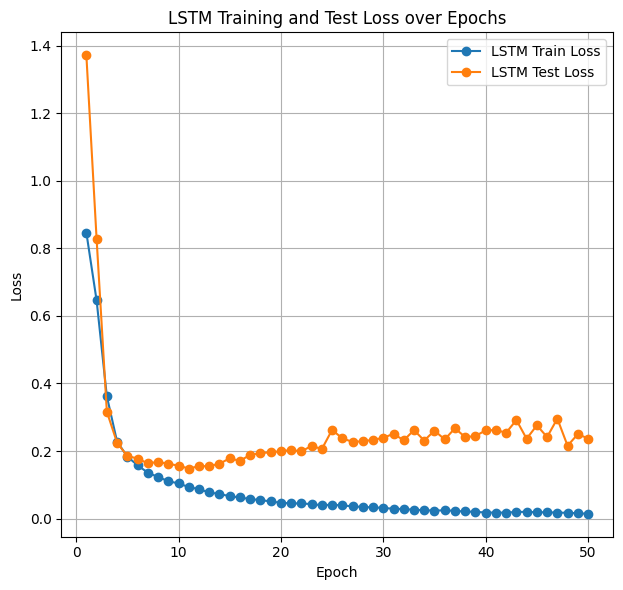

In [508]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(lstm_data['Epoch'], lstm_data['Train_Loss'], label='LSTM Train Loss', marker='o')
plt.plot(lstm_data['Epoch'], lstm_data['Test_Loss'], label='LSTM Test Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

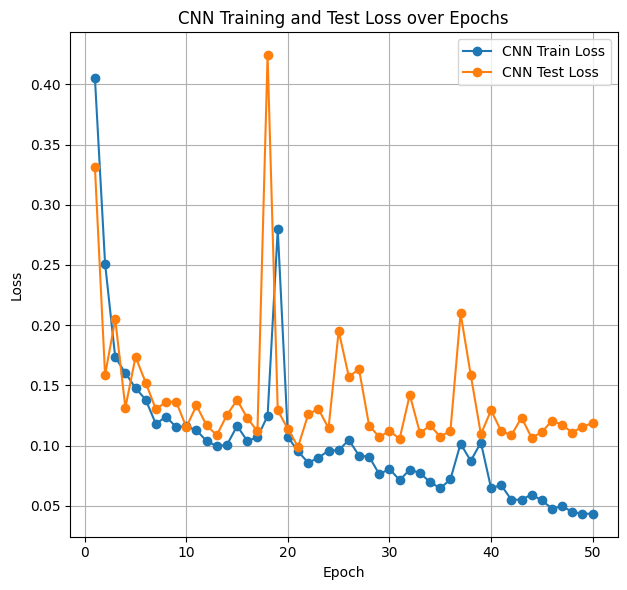

In [509]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.plot(cnn_data['Epoch'], cnn_data['Train_Loss'], label='CNN Train Loss', marker='o')
plt.plot(cnn_data['Epoch'], cnn_data['Test_Loss'], label='CNN Test Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [510]:
# Restricted DF with only main assets and capital values (+ additional columns for change)

# lstm_results
RMSE: 0.3462441861629486
MAE: 0.14099374413490295
R²: 0.9200827409988592

# cnn_results
RMSE: 0.3420768976211548
MAE: 0.12758944928646088
R²: 0.9219948847835346

In [511]:
lstm_data = pd.read_csv('mini/lstm_training_results.csv')
cnn_data = pd.read_csv('mini/cnn_training_results.csv')

In [512]:
lstm_data.columns = ['Epoch', 'Train_Loss', 'Test_Loss']
cnn_data.columns = ['Epoch', 'Train_Loss', 'Test_Loss']

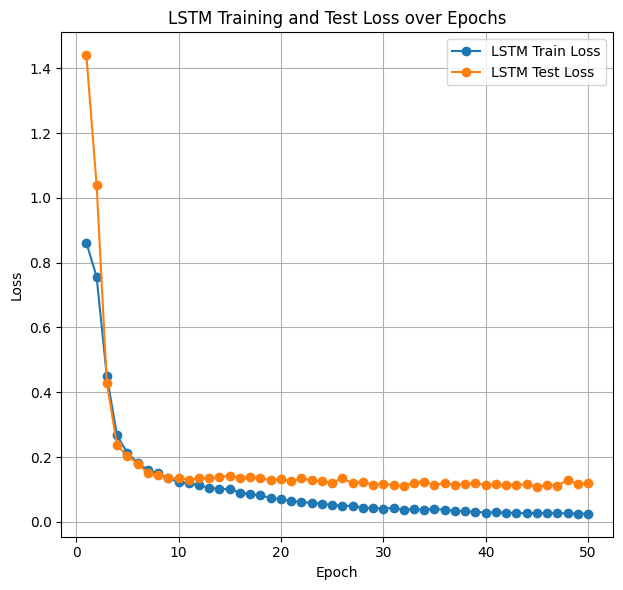

In [513]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(lstm_data['Epoch'], lstm_data['Train_Loss'], label='LSTM Train Loss', marker='o')
plt.plot(lstm_data['Epoch'], lstm_data['Test_Loss'], label='LSTM Test Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

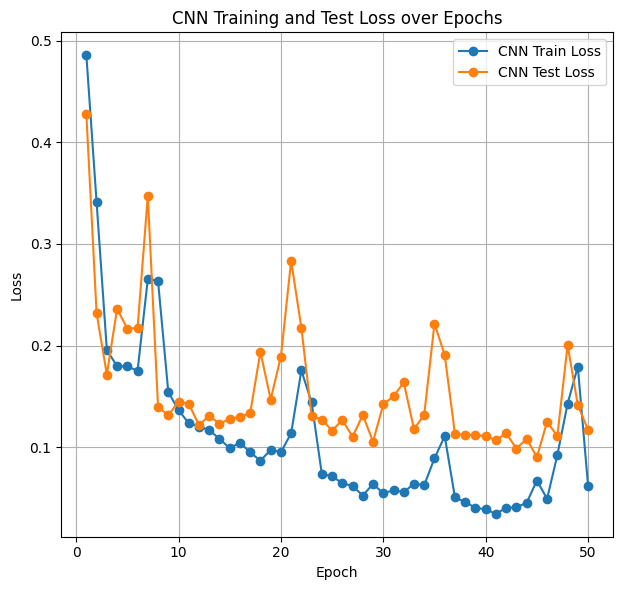

In [514]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.plot(cnn_data['Epoch'], cnn_data['Train_Loss'], label='CNN Train Loss', marker='o')
plt.plot(cnn_data['Epoch'], cnn_data['Test_Loss'], label='CNN Test Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()